In [1]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import emcee
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.time import Time
import lightkurve as lk

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv('../data/preliminary_results.csv')

In [3]:
df

,date,ew,ew_unc,file_basename,full_filepath,gaussian_width,gaussian_width_unc,int_wv,jd,n_samples,obs_line_center,obs_line_center_unc,qidx,star_name,time
0,2020-07-16,1.395743,1.181927e-02,Goldilocks_20200716T094818_v1.0_0033.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.106646,8.985081e-03,8542.0,2.459047e+06,5000.0,8.542580e+03,5.904067e-03,6245.0,HAT-P-11,09:48:47
1,2020-07-16,1.393962,1.222317e-02,Goldilocks_20200716T095404_v1.0_0034.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.105402,9.202246e-03,8542.0,2.459047e+06,5000.0,8.542570e+03,6.376022e-03,6245.0,HAT-P-11,09:54:28
2,2020-07-24,1.363680,1.153400e-02,Goldilocks_20200724T094542_v1.0_0025.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.020919,8.568031e-03,8542.0,2.459055e+06,5000.0,8.542622e+03,5.690058e-03,7146.0,HAT-P-11,09:46:12
3,2020-07-24,1.353340,1.179830e-02,Goldilocks_20200724T095128_v1.0_0026.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.016422,8.953680e-03,8542.0,2.459055e+06,5000.0,8.542621e+03,6.048049e-03,7146.0,HAT-P-11,09:51:53
4,2020-08-01,1.350427,1.515268e-02,Goldilocks_20200801T030803_v1.0_0004.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.006933,1.134170e-02,8542.0,2.459063e+06,5000.0,8.542646e+03,7.465504e-03,7226.0,HAT-P-11,03:08:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,2019-10-22,-0.691427,2.336325e-02,Goldilocks_20191022T020027_v1.0_0006.spectra.fits,../data/HPF/Helium-transit-data\WASP-69b\out-o...,1.343556,2.878386e-02,8542.0,2.458779e+06,5000.0,8.541701e+03,3.355662e-02,NaN,WASP_69_out_1_after_4,02:00:52
401,2020-07-23,17.731751,2.055538e+00,Goldilocks_20200723T055838_v1.0_0006.spectra.fits,../data/HPF/Helium-transit-data\WASP-80b\Goldi...,7.572096,1.366191e+00,8542.0,2.459054e+06,5000.0,8.534557e+03,1.348364e+00,7144.0,WASP-80,05:59:07
402,2020-07-23,804957.885020,4.804489e+06,Goldilocks_20200723T060741_v1.0_0007.spectra.fits,../data/HPF/Helium-transit-data\WASP-80b\Goldi...,990695.465321,5.882518e+06,8542.0,2.459054e+06,5000.0,-8.794204e+07,1.864819e+09,7144.0,WASP-80,06:08:11
403,2020-08-01,-1.055729,1.344991e-01,Goldilocks_20200801T052720_v1.0_0023.spectra.fits,../data/HPF/Helium-transit-data\WASP-80b\Goldi...,1.575354,8.242386e-02,8542.0,2.459063e+06,5000.0,8.540966e+03,9.178269e-02,7224.0,WASP-80,05:27:48


In [4]:
pd.options.display.max_rows = 100

In [5]:
df.star_name.value_counts()

HAT-P-67b_IN_2                14
HAT-P-67b_IN_1                14
HAT-P-17b_IN_1b               11
HAT-P-17b_IN_3                10
HAT-P-67b_IN_3                 9
HAT-P-67b_OUT_same3            9
WASP_69_in_2                   7
HAT-P-32_3_IN                  6
HAT-P-17b                      6
HD189733                       6
HAT-P-11                       6
HAT-P-17b_OUT_1b_before1       6
HAT-P-32_1_IN                  6
TrES-1                         6
k2-266_in                      6
k2-266_out_same                6
HAT-P-12_OUT_2                 5
Tres-1b_4_same                 5
HAT-P-12_OUT_1                 5
Tres-1b_IN_4                   5
HAT-P-12_OUT_1_before2         5
HAT-P-12_IN_2                  5
WASP-127_OUT_before1           5
Tres-1b_IN_2b                  5
HAT-P-17b_OUT_3_same           4
HAT-P-17b_OUT_3_after2         4
WASP-80                        4
HAT-P-17b_OUT_3_before1        4
WASP-177_2_IN                  4
WASP-177_1_OUT_a2              4
HAT-P-32_3

We retrieved the data for the planets from [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/)

In [6]:
target_name = 'k2-266'
orbital_period = 2.15000820
t_c = 2455867.402743
t_c_btjd = t_c-2457000.0 #neg value means discovered before TESS

In [7]:
target_mask = df.star_name.str.contains(target_name)
df = df[target_mask]
keep_mask = df.ew_unc < 10 #original value = 1

In [8]:
df

,date,ew,ew_unc,file_basename,full_filepath,gaussian_width,gaussian_width_unc,int_wv,jd,n_samples,obs_line_center,obs_line_center_unc,qidx,star_name,time
253,2020-03-11,-1.208707,0.064730,Goldilocks_20200311T042556_v1.0_0014.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\in-tra...,1.391725,0.042456,8542.0,2.458920e+06,5000.0,8541.722564,0.052201,3201.0,k2-266_in,04:26:25
254,2020-03-11,-1.352456,0.078029,Goldilocks_20200311T043503_v1.0_0015.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\in-tra...,1.483276,0.045571,8542.0,2.458920e+06,5000.0,8541.605819,0.055371,3201.0,k2-266_in,04:35:29
255,2020-03-11,-1.351537,0.066223,Goldilocks_20200311T044409_v1.0_0016.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\in-tra...,1.458055,0.039019,8542.0,2.458920e+06,5000.0,8541.653018,0.049023,3201.0,k2-266_in,04:44:33
256,2020-03-11,-1.319919,0.065225,Goldilocks_20200311T045309_v1.0_0017.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\in-tra...,1.415306,0.038613,8542.0,2.458920e+06,5000.0,8541.647350,0.048854,3201.0,k2-266_in,04:53:36
257,2020-03-11,-1.159824,0.070098,Goldilocks_20200311T050215_v1.0_0018.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\in-tra...,1.409197,0.048543,8542.0,2.458920e+06,5000.0,8541.660844,0.059591,3201.0,k2-266_in,05:02:40
258,2020-03-11,-1.222217,0.065890,Goldilocks_20200311T051120_v1.0_0019.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\in-tra...,1.360513,0.043123,8542.0,2.458920e+06,5000.0,8541.746896,0.053839,3201.0,k2-266_in,05:11:44
259,2020-03-10,-1.252564,0.062587,Goldilocks_20200310T071215_v1.0_0024.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\out-of...,1.450521,0.040748,8542.0,2.458919e+06,5000.0,8541.654739,0.051378,3203.0,k2-266_out_before1,07:12:42
260,2020-03-10,-1.302001,0.058929,Goldilocks_20200310T072121_v1.0_0025.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\out-of...,1.432457,0.036280,8542.0,2.458919e+06,5000.0,8541.674775,0.045620,3203.0,k2-266_out_before1,07:21:46
261,2020-03-10,-1.313462,0.062797,Goldilocks_20200310T073021_v1.0_0026.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\out-of...,1.398967,0.037251,8542.0,2.458919e+06,5000.0,8541.703604,0.046717,3203.0,k2-266_out_before1,07:30:50
262,2020-03-10,-1.216925,0.056997,Goldilocks_20200310T073928_v1.0_0027.spectra.fits,../data/HPF/Helium-transit-data\K2-266b\out-of...,1.360954,0.037910,8542.0,2.458919e+06,5000.0,8541.728704,0.048169,3203.0,k2-266_out_before1,07:39:53


In [8]:
df = df[keep_mask]
in_transit_mask = df.star_name.str.contains('_IN')

In [9]:
df['ew']=df.ew.astype(np.float).values #change str to float
df['btjd']=df['jd']-2457000.0 #cut down JD to smaller scale

In [10]:
sn_ratio=2
good_data_mask=(df.ew/df.ew_unc)>sn_ratio #signal to noise ratio

In [11]:
df=df[good_data_mask]

In [12]:
x_line=df['ew'].median() #calculate horizontal line going between in/out of transit points
x_line

1.103845279282398

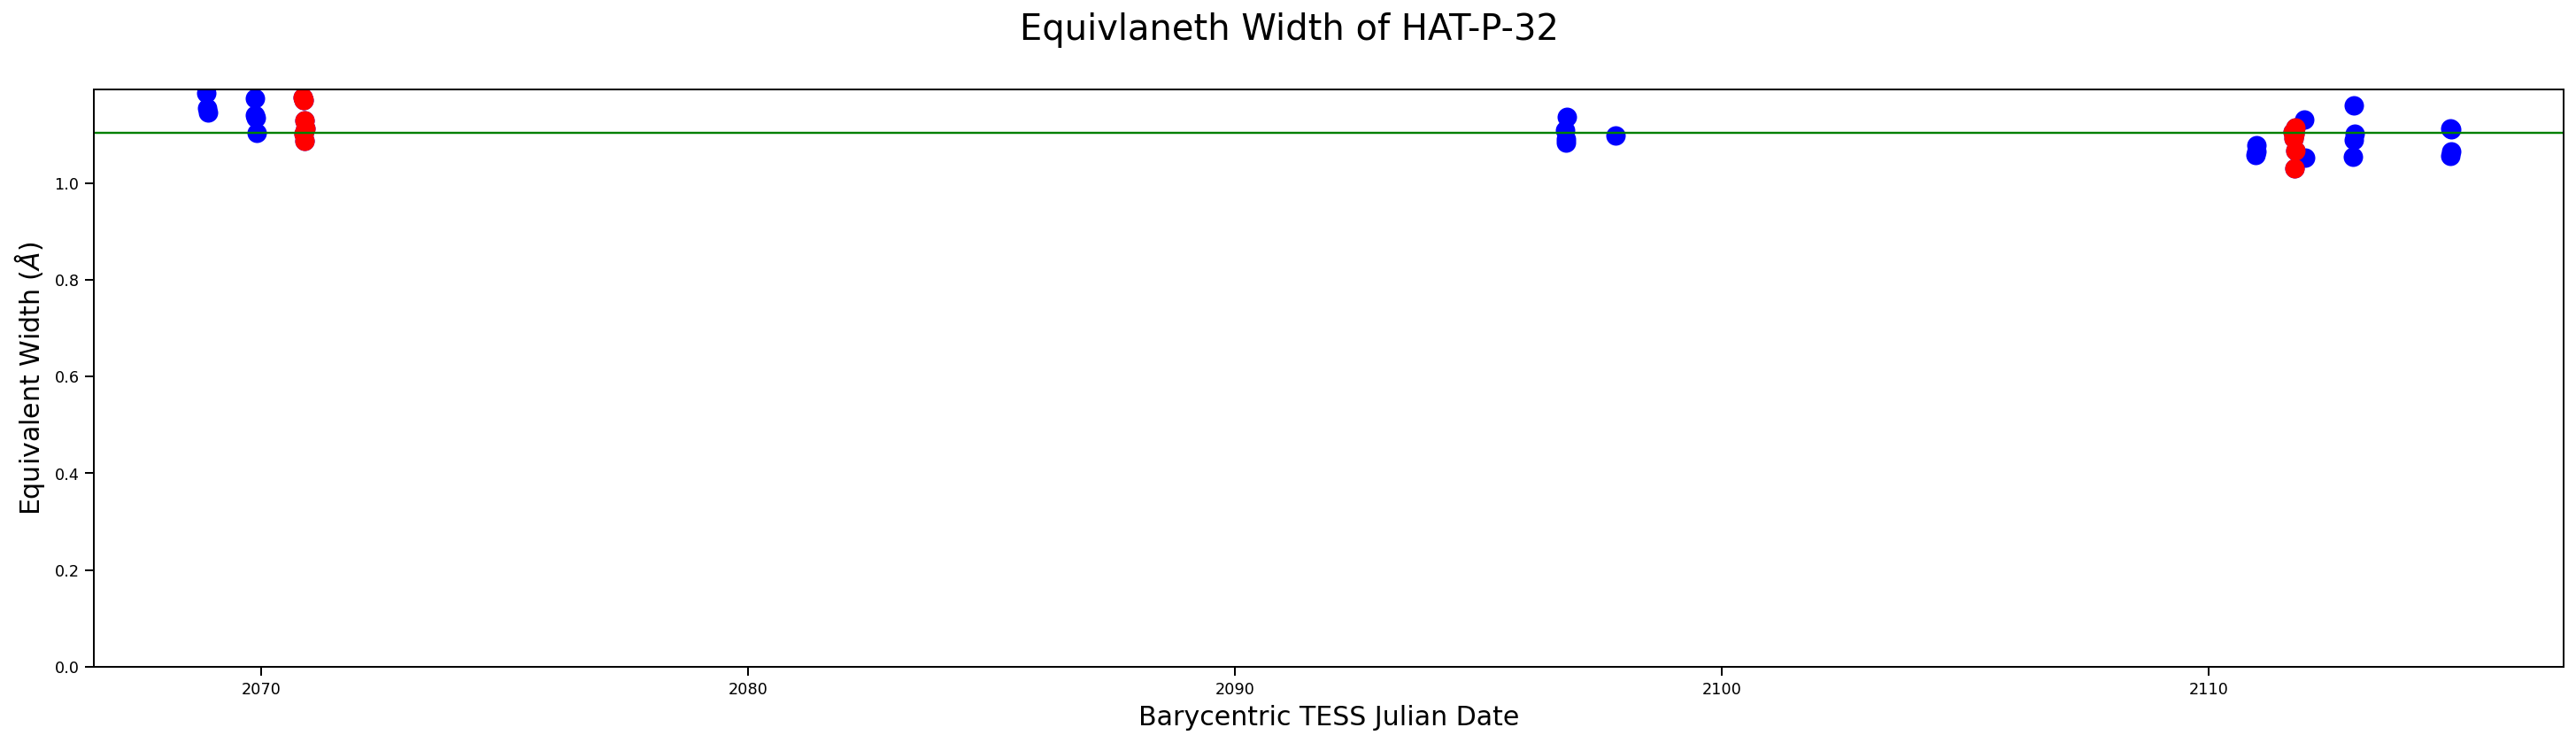

In [14]:
plt.figure(figsize=(25,6))
#plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd, df.ew, 'bo', markersize=10)
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(0)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

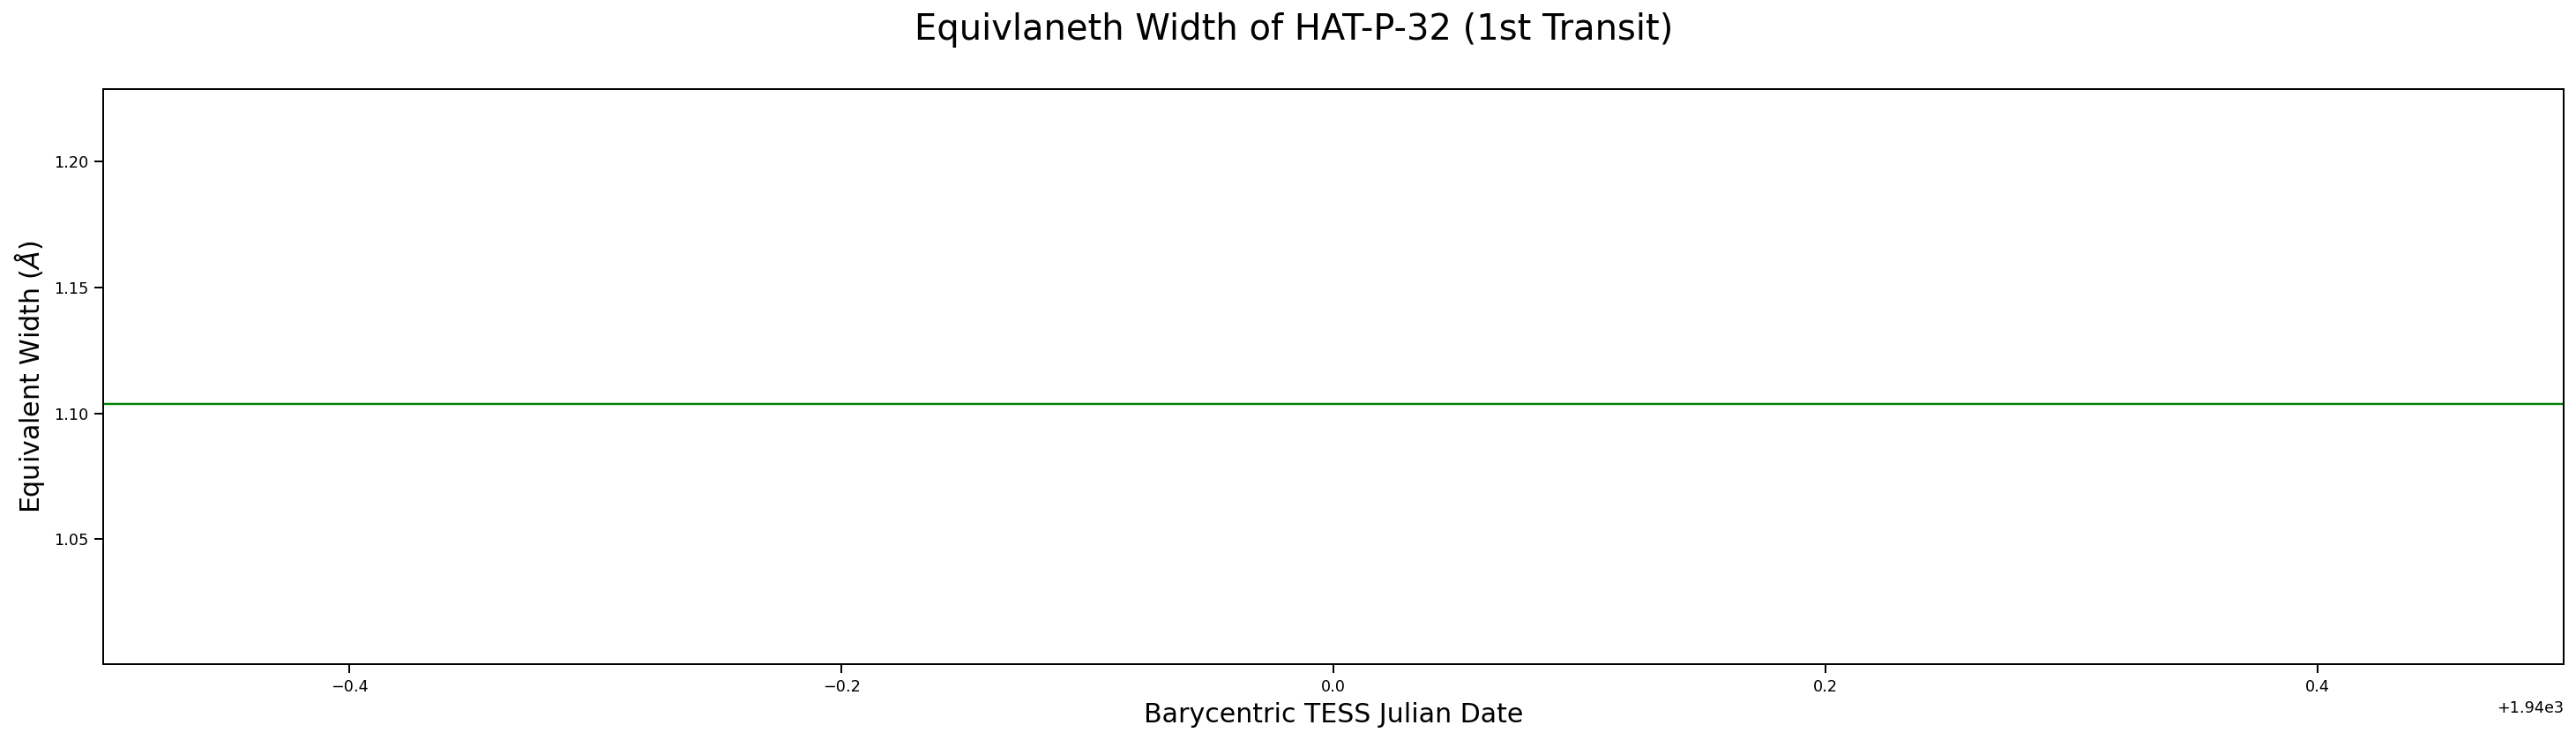

In [15]:
#1st in transit plot
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(1.05,1.25)
plt.xlim(1939.5,1940.5)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name} (1st Transit)', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig(f'../figures/IN_TRANSIT_1_{target_name}.jpg')

In [ ]:
#2nd in transit plot
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(1.0,1.2)
plt.xlim(2111.5,2112)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name} (2nd Transit)', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig(f'../figures/IN_TRANSIT_2_{target_name}.jpg')

Let's compute the normalized phase shifted so that the transit midpoint always occurs at zero while also seeing the light curve before and after the midpoint.

$$\phi=\frac{\mod(t-T_c+\frac{P}{2}\;,P)}{P} -0.5$$ 

In [16]:
df['phase']=np.mod(df.btjd-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
#df['normalized_phase']=(df['phase']/orbital_period)-0.5

In [17]:
df.describe() #max less than orbital period, normalized less than 1

,ew,ew_unc,gaussian_width,gaussian_width_unc,int_wv,jd,n_samples,obs_line_center,obs_line_center_unc,qidx,btjd,phase
count,37.000000,37.000000,37.000000,37.000000,37.0,3.700000e+01,37.0,37.000000,37.000000,37.000000,37.000000,37.000000
mean,1.107662,0.025232,0.886546,0.019902,8542.0,2.459096e+06,5000.0,8543.165452,0.012529,5531.702703,2095.560277,-0.225049
std,0.039134,0.006019,0.028773,0.004648,0.0,1.971388e+01,0.0,0.080122,0.003300,554.925213,19.713882,0.613014
min,1.030028,0.016465,0.827273,0.013191,8542.0,2.459069e+06,5000.0,8543.043228,0.008109,4967.000000,2068.863506,-1.074142
25%,1.083076,0.021938,0.866810,0.017369,8542.0,2.459071e+06,5000.0,8543.087762,0.010754,4969.000000,2070.869201,-0.918971
50%,1.103845,0.022810,0.888324,0.018201,8542.0,2.459111e+06,5000.0,8543.185369,0.011378,6062.000000,2110.969856,-0.026019
75%,1.134430,0.028587,0.904978,0.022376,8542.0,2.459112e+06,5000.0,8543.239452,0.013981,6065.000000,2111.971841,0.092682
max,1.186175,0.042977,0.958019,0.034241,8542.0,2.459115e+06,5000.0,8543.288142,0.023674,6067.000000,2114.990991,1.065995


In [18]:
plt.figure(figsize=(25,6))

plt.errorbar(df.normalized_phase, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.normalized_phase[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

plt.errorbar(df.normalized_phase-1, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.normalized_phase[in_transit_mask]-1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

plt.errorbar(df.normalized_phase+1, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.normalized_phase[in_transit_mask]+1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.ylim(0.9,1.32)
plt.xlim(-1.5,1.5)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

AttributeError: 'DataFrame' object has no attribute 'normalized_phase'

<Figure size 1800x432 with 0 Axes>

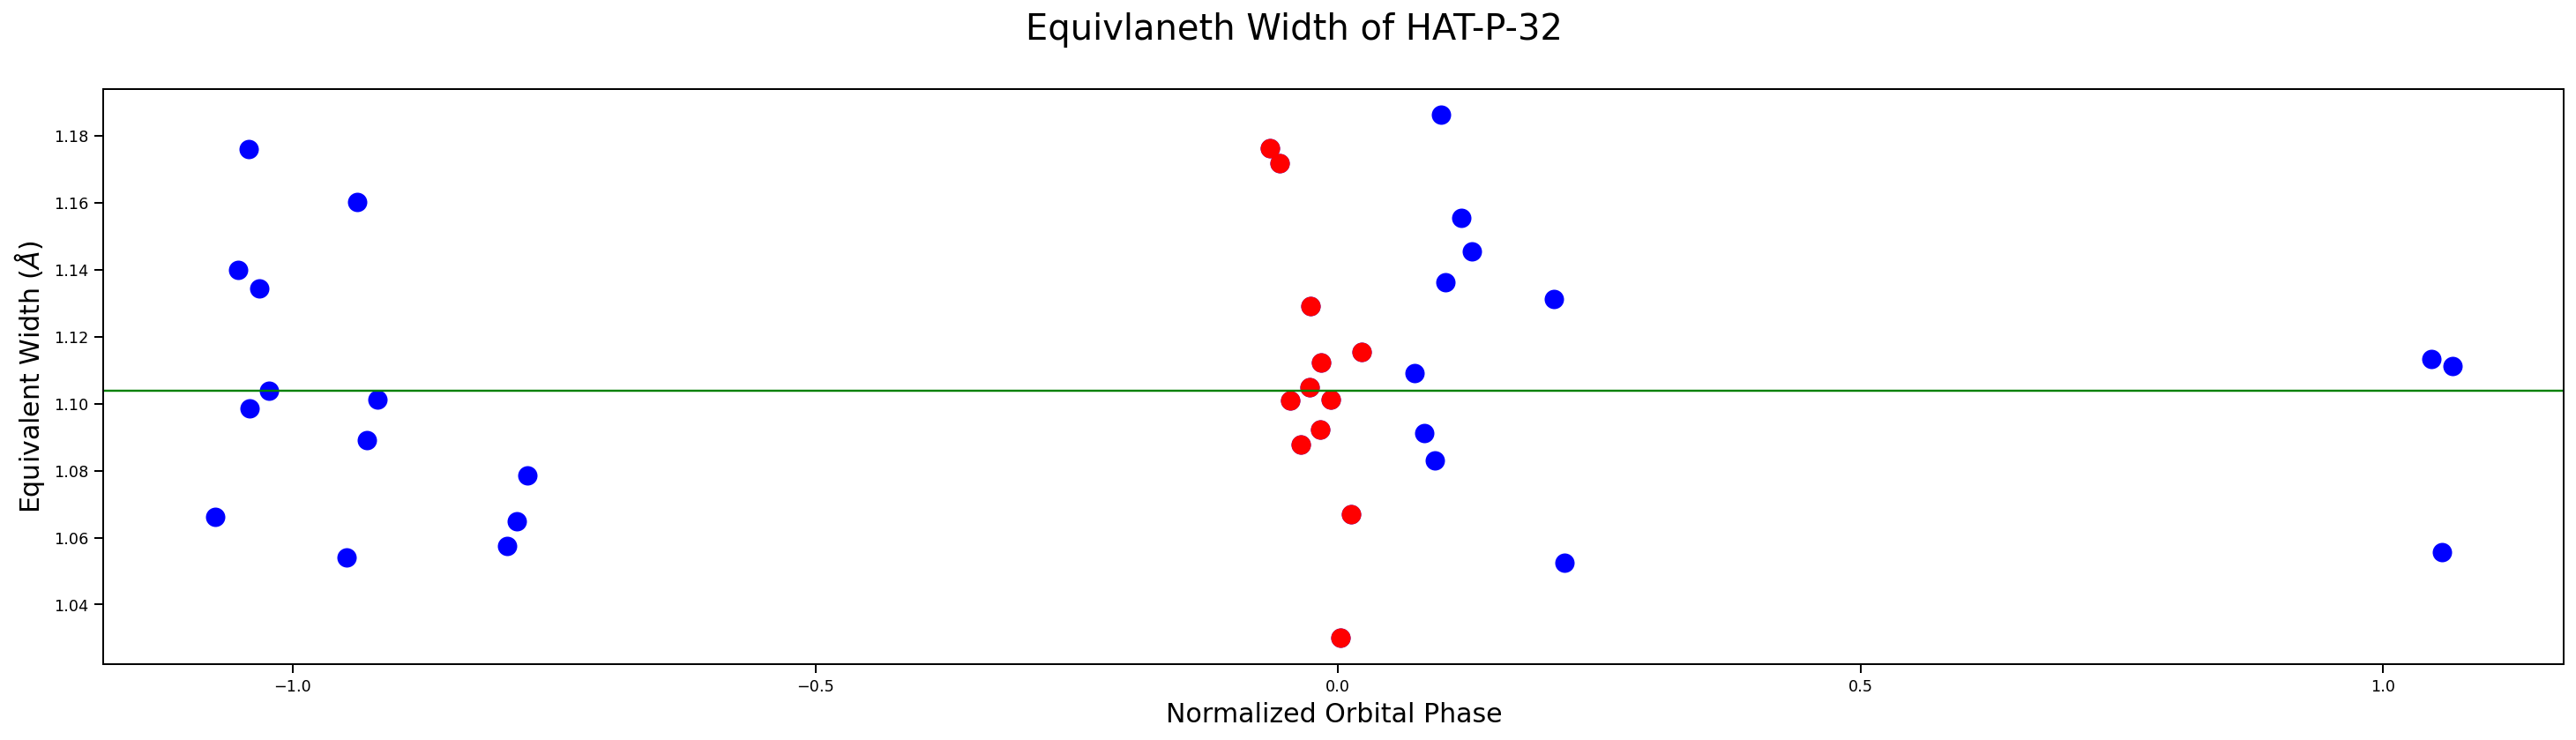

In [19]:
plt.figure(figsize=(25,6))

plt.plot(df.phase, df.ew, 'bo', markersize=10)
plt.plot(df.phase[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.plot(df.normalized_phase-1, df.ew, 'bo', markersize=10)
#plt.plot(df.normalized_phase[in_transit_mask]-1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.plot(df.normalized_phase+1, df.ew, 'bo', markersize=10)
#plt.plot(df.normalized_phase[in_transit_mask]+1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.ylim(0.9,1.32)
#plt.xlim(-2,2)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

Let's define a variable called 'shifted' in two steps.

In [ ]:
second_half_mask = df.normalized_phase > 0.5
first_half_mask = ~second_half_mask

In [ ]:
df['shifted']=df.normalized_phase
df.shifted[second_half_mask]=df.shifted[second_half_mask]-1
df.shifted[second_half_mask]

In [ ]:
plt.figure(figsize=(25,6))
plt.errorbar(df.shifted, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.shifted[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(0.9,1.32)
plt.xlim(0,1)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

# Light curve analysis with TESS

In [23]:
sr = lk.search_lightcurve(target_name)
lc_raw = sr[1].download()

C:\Users\jojoa\.conda\envs\disperse_env\lib\site-packages\lightkurve\lightcurve.py:965: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


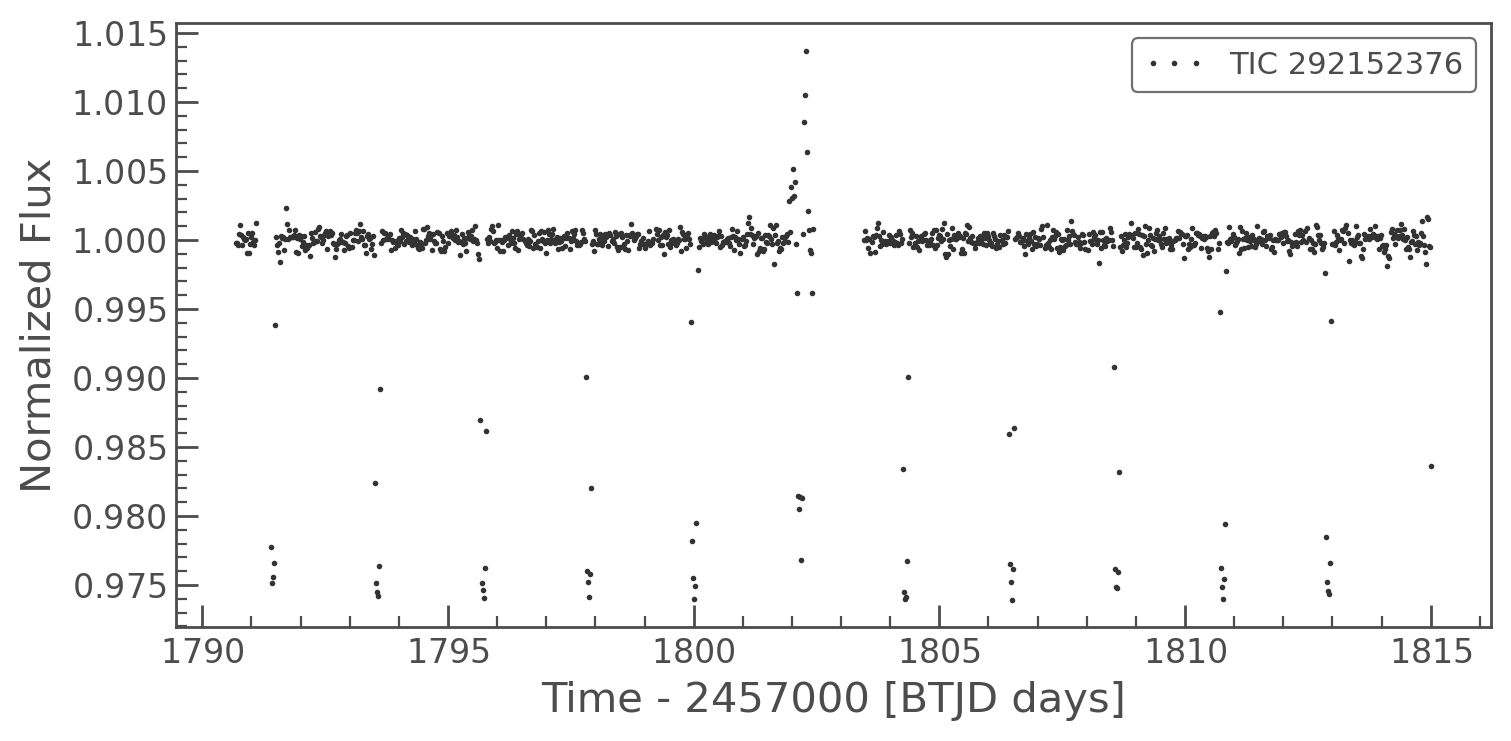

In [24]:
ax = lc_raw.normalize().plot(marker='.', linestyle='none')
#ax.set_ylim(0, 1.05)

C:\Users\jojoa\.conda\envs\disperse_env\lib\site-packages\lightkurve\lightcurve.py:965: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


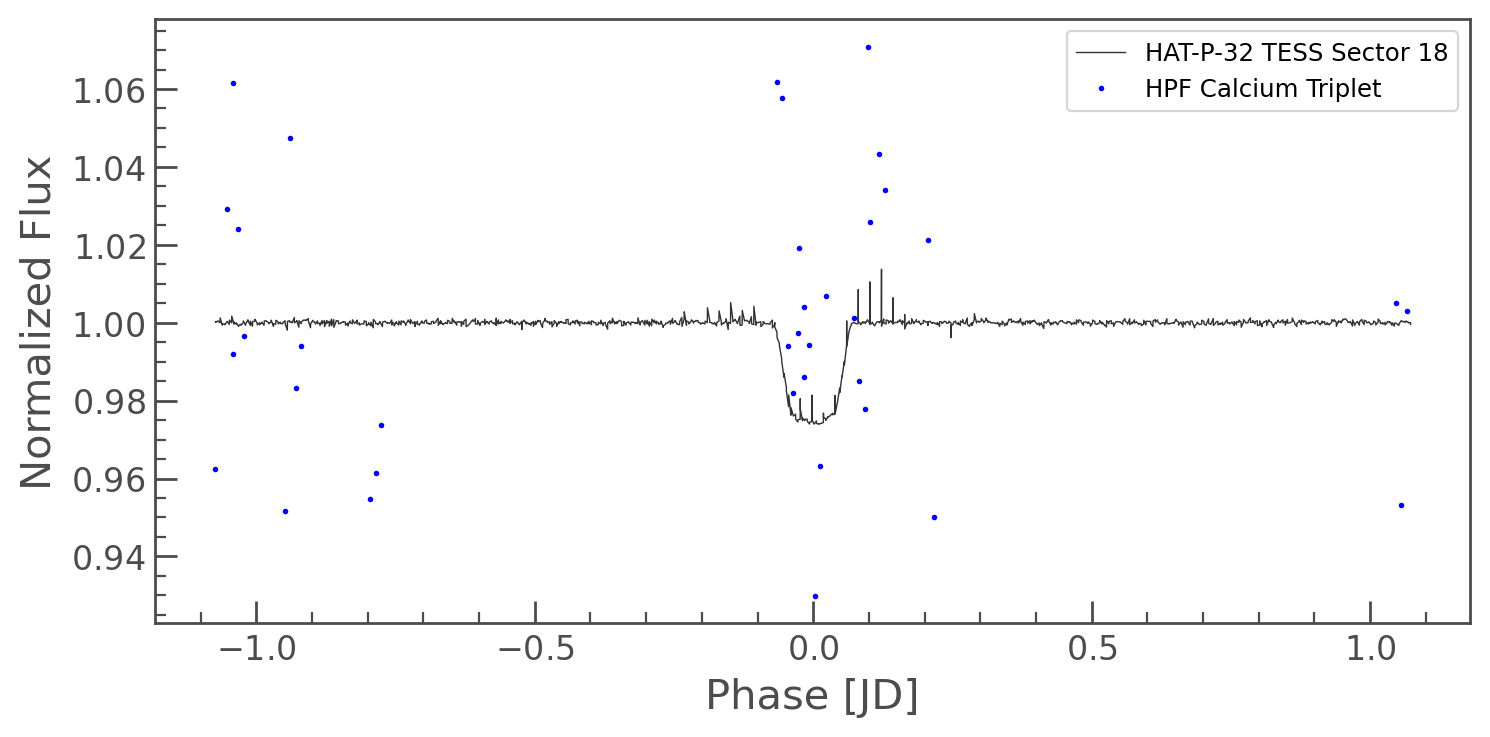

In [28]:
lc_folded = lc_raw.fold(period=orbital_period, epoch_time=t_c_btjd).normalize()
ax = lc_folded.plot(label = target_name+' TESS Sector 18')
plt.plot(df.phase, df.ew/np.mean(df.ew), 'bo', markersize=1, label = 'HPF Calcium Triplet')
plt.legend()
#plt.ylim(0)
plt.savefig(f'../figures/TESS_EW_{target_name}_1.jpg')

# Exploring different exposure times in the same sector

In [ ]:
sr = lk.search_lightcurve(target_name)
lc_raw = sr[0].download()

In [ ]:
ax = lc_raw.normalize().plot(marker='.', linestyle='none')
#ax.set_ylim(0, 1.05)

In [ ]:
lc_folded = lc_raw.fold(period=orbital_period, epoch_time=t_c_btjd).normalize()
ax = lc_folded.plot(label = target_name+' TESS Sector 24')
plt.plot(df.phase, df.ew/np.mean(df.ew), 'bo', markersize=1, label = 'HPF Calcium Triplet')
plt.legend()
plt.savefig(f'../figures/TESS_EW_{target_name}_0.jpg')